In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import torch.nn.functional as F


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import numpy as np
import pandas as pd
from PIL import Image
import os
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Aesthetic progress bar

In [ ]:
from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Import Dataset

In order to use the data, you will need to go to the Kaggle website and download a kaggle.json token. We used the kaggle API in order to get the image data since it was crashing when we tried to put it into our shared google drive. Instructions are as followed


1) Go to the kaggle website

2) Click your profile picture on the top right of the screen

3) Click 'Settings' from the menu bar that showed up after pressing the profile picture

4) Click Create New Token for the kaggle API

5) use the kaggle.json() for the files upload in the code below

In [ ]:
from google.colab import files
files.upload()  # Upload the kaggle.json file

{}

Unpacking and loading (can take a while)

In [ ]:
%%capture
# turns off printed output

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c isic-2024-challenge
!unzip isic-2024-challenge.zip -d isic-2024-challenge

train_metadata_df = pd.read_csv('/content/isic-2024-challenge/train-metadata.csv')
image_files = os.listdir('/content/isic-2024-challenge/train-image/image')
img_path = Path("/content/isic-2024-challenge/train-image/image")

train_metadata_df['img_path'] = train_metadata_df['isic_id'].apply(lambda x: img_path / f"{x}.jpg")

## Define Dataset for loading



In [ ]:
# Image Transformation
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 224x224 pixels
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.dataframe.iloc[idx]['img_path']
        image = Image.open(img_path)

        # Apply transformations to the image
        if self.transform:
            image = self.transform(image)

        # Get the label
        label = torch.tensor(self.dataframe.iloc[idx]['target'], dtype=torch.long)

        return image, label

Preparing dataset into dataloaders

In [ ]:
dataset = ImageDataset(train_metadata_df, transform=transform)

train_data, test_data = random_split(dataset, (.8,.2))

In [ ]:
# making a weighted sampler to handle the severely unbalanced data
y_train = [dataset.dataframe['target'][i] for i in train_data.indices]

weight = 1. / np.array([320539,308]) # weights based on class counts
class_weights = torch.tensor(weight, dtype=torch.float).to(device) # used for optionally weighting loss function later
samples_weight = np.array([weight[t] for t in y_train])
samples_weight = torch.from_numpy(samples_weight)

sampler = torch.utils.data.WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight)) # plugged into dataloader

In [ ]:
# Make dataloader
batch_size = 16

train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=2, sampler=sampler)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=2)

In [ ]:
# run for unweighted sampling
# train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=2, shuffle=True)

### Define Models

In [ ]:
class SimpleCnn(nn.Module):
    # needs innit, forward
    def __init__(self) -> None:
        super().__init__()
        # input 128*128, output 2

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(in_features=32 * 32 * 32, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class BiggerCnn(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        # Input: 128x128x3
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)  # Output: 128x128x32
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)  # Output: 64x64x64
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)  # Output: 32x32x128
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)  # Output: 16x16x256
        self.bn4 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(in_features=256 * 8 * 8, out_features=1024)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=1024, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        x = x.view(-1, 256 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class Resnet18(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.resnet18()

    def forward(self, x):
        return self.model(x)

### Training

In [ ]:
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=1, keep_losses=False):
    model.to(device)

    out = display(progress(0, len(train_loader)), display_id=True) # progress bar

    if keep_losses:
        losses = []

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()  # Clear the gradients
            output = model(data)  # Forward pass
            loss = criterion(output, target)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            if keep_losses:
                losses.append(loss.item())

            out.update(progress(batch_idx, len(train_loader)))

    if keep_losses:
        return losses

#### Training Resnet18

In [ ]:
resnet18 = Resnet18() # run to create new model / reset params

NameError: name 'Resnet18' is not defined

In [ ]:
criterion = nn.CrossEntropyLoss()
# criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.001,0.999]).to(device))   # Weighted
optimizer = optim.Adam(resnet18.parameters(), lr=0.01)

train_model(resnet18, train_loader, criterion, optimizer, device)

#### Training Simple CNN

In [ ]:
simple_cnn = SimpleCnn()  # run to create new model / reset params

In [ ]:
criterion = nn.CrossEntropyLoss()
# criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.001,0.999]).to(device))   # Weighted
optimizer = optim.Adam(simple_cnn.parameters(), lr=0.01)

train_model(simple_cnn, train_loader, criterion, optimizer, device)

Epoch 1/1, Batch 0/20053, Loss: 0.017127810046076775
Epoch 1/1, Batch 100/20053, Loss: 0.008706820197403431
Epoch 1/1, Batch 200/20053, Loss: 0.01023543905466795
Epoch 1/1, Batch 300/20053, Loss: 0.008987213484942913
Epoch 1/1, Batch 400/20053, Loss: 0.013407308608293533
Epoch 1/1, Batch 500/20053, Loss: 0.014263582415878773
Epoch 1/1, Batch 600/20053, Loss: 0.01566239818930626
Epoch 1/1, Batch 700/20053, Loss: 0.025053180754184723
Epoch 1/1, Batch 800/20053, Loss: 0.01895551010966301
Epoch 1/1, Batch 900/20053, Loss: 0.014925243332982063
Epoch 1/1, Batch 1000/20053, Loss: 0.0178216565400362
Epoch 1/1, Batch 1100/20053, Loss: 0.01670057885348797
Epoch 1/1, Batch 1200/20053, Loss: 0.017905617132782936
Epoch 1/1, Batch 1300/20053, Loss: 0.01899470016360283
Epoch 1/1, Batch 1400/20053, Loss: 0.018977969884872437
Epoch 1/1, Batch 1500/20053, Loss: 0.021267807111144066
Epoch 1/1, Batch 1600/20053, Loss: 0.01838020235300064
Epoch 1/1, Batch 1700/20053, Loss: 0.014404242858290672
Epoch 1/1, B

#### Training Bigger CNN

In [ ]:
big_cnn = BiggerCnn()  # run to create new model / reset params

In [ ]:
criterion = nn.CrossEntropyLoss()
# criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.001,0.999]).to(device))   # Weighted
optimizer = optim.Adam(big_cnn.parameters(), lr=0.01)

train_model(big_cnn, train_loader, criterion, optimizer, device)

Epoch 1/1, Batch 0/20053, Loss: 0.023597562685608864
Epoch 1/1, Batch 100/20053, Loss: 0.012914171442389488
Epoch 1/1, Batch 200/20053, Loss: 0.004157290328294039
Epoch 1/1, Batch 300/20053, Loss: 0.0007220639381557703
Epoch 1/1, Batch 400/20053, Loss: 0.006541479378938675
Epoch 1/1, Batch 500/20053, Loss: 1.2002583389403298e-05
Epoch 1/1, Batch 600/20053, Loss: 0.00921808835119009
Epoch 1/1, Batch 700/20053, Loss: 0.02507380023598671
Epoch 1/1, Batch 800/20053, Loss: 0.2953304648399353
Epoch 1/1, Batch 900/20053, Loss: 0.0012834807857871056
Epoch 1/1, Batch 1000/20053, Loss: 0.005874120630323887
Epoch 1/1, Batch 1100/20053, Loss: 0.013013700023293495
Epoch 1/1, Batch 1200/20053, Loss: 0.013653372414410114
Epoch 1/1, Batch 1300/20053, Loss: 0.0022093357983976603
Epoch 1/1, Batch 1400/20053, Loss: 0.008906200528144836
Epoch 1/1, Batch 1500/20053, Loss: 0.026360638439655304
Epoch 1/1, Batch 1600/20053, Loss: 0.021585719659924507
Epoch 1/1, Batch 1700/20053, Loss: 0.23236019909381866
Epoc

## Evaluation

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc

def partial_auc(y_true, y_score, min_tpr=0.8):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    max_fpr = 1 - min_tpr

    # Add a single point at max_fpr by linear interpolation
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)

    partial_auc = auc(fpr, tpr)
    return partial_auc


In [ ]:
def evaluate_model(model, data_loader, device, min_tpr=0.8, loss_fn = nn.CrossEntropyLoss()):
    out = display(progress(0, len(data_loader)), display_id=True)

    model.eval()
    all_targets = []
    all_probabilities = []
    total_batches = len(data_loader)
    loss=[]

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            probabilities = torch.softmax(output, dim=1)
            all_targets.extend(target.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
            loss.append(loss_fn(output, target).item())
            out.update(progress(batch_idx, total_batches))

    all_targets = np.array(all_targets)
    all_probabilities = np.array(all_probabilities)

    # Generate classification report
    predicted_labels = np.argmax(all_probabilities, axis=1)
    report = classification_report(all_targets, predicted_labels)
    print("Classification Report:\n", report)

    # Calculate AUC-ROC score
    if len(np.unique(all_targets)) == 2:
        # For binary classification
        auc_roc = roc_auc_score(all_targets, all_probabilities[:, 1])
        # Calculate pAUC
        pauc = partial_auc(all_targets, all_probabilities[:, 1], min_tpr)
    else:
        # For multi-class classification, use 'ovr' (one-vs-rest)
        auc_roc = roc_auc_score(all_targets, all_probabilities, multi_class='ovr')
        # Calculate pAUC for each class
        pauc = [partial_auc((all_targets == i).astype(int), all_probabilities[:, i], min_tpr)
                for i in range(all_probabilities.shape[1])]
        pauc = np.mean(pauc)  # Average pAUC across all classes

    print(f"Partial AUC (min_tpr={min_tpr}):", pauc)

    return loss, (report, pauc)

#### Evaluating

In [ ]:
evaluate_model(simple_cnn, test_loader, device)

Batch 0/5014, Precision(incomplete): [1.], Recall(incomplete): [1.]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Batch 200/5014, Precision(incomplete): [0.99813433 0.        ], Recall(incomplete): [1. 0.]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Batch 400/5014, Precision(incomplete): [0.99828554 0.        ], Recall(incomplete): [1. 0.]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Batch 600/5014, Precision(incomplete): [0.99864809 0.        ], Recall(incomplete): [1. 0.]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Batch 800/5014, Precision(incomplete): [0.99890762 0.        ], Recall(incomplete): [1. 0.]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Batch 1000/5014, Precision(incomplete): [0.99893856 0.        ], Recall(incomplete): [1. 0.]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Batch 1200/5014, Precision(incomplete): [0.99890716 0.        ], Recall(incomplete): [1. 0.]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Batch 1400/5014, Precision(incomplete): [0.99888473 0.        ], Recall(incomplete): [1. 0.]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Batch 1600/5014, Precision(incomplete): [0.99871174 0.        ], Recall(incomplete): [1. 0.]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Batch 1800/5014, Precision(incomplete): [0.99868129 0.        ], Recall(incomplete): [1. 0.]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Batch 2000/5014, Precision(incomplete): [0.99871939 0.        ], Recall(incomplete): [1. 0.]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Batch 2200/5014, Precision(incomplete): [0.99875057 0.        ], Recall(incomplete): [1. 0.]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Batch 2400/5014, Precision(incomplete): [0.99882861 0.        ], Recall(incomplete): [1. 0.]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Batch 2600/5014, Precision(incomplete): [0.99887063 0.        ], Recall(incomplete): [1. 0.]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Batch 2800/5014, Precision(incomplete): [0.99886201 0.        ], Recall(incomplete): [1. 0.]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Batch 3000/5014, Precision(incomplete): [0.9988962 0.       ], Recall(incomplete): [1. 0.]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Batch 3200/5014, Precision(incomplete): [0.99890659 0.        ], Recall(incomplete): [1. 0.]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Batch 3400/5014, Precision(incomplete): [0.99891576 0.        ], Recall(incomplete): [1. 0.]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Batch 3600/5014, Precision(incomplete): [0.99892391 0.        ], Recall(incomplete): [1. 0.]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Batch 3800/5014, Precision(incomplete): [0.99891476 0.        ], Recall(incomplete): [1. 0.]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Batch 4000/5014, Precision(incomplete): [0.99895339 0.        ], Recall(incomplete): [1. 0.]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Batch 4200/5014, Precision(incomplete): [0.99897346 0.        ], Recall(incomplete): [1. 0.]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Batch 4400/5014, Precision(incomplete): [0.9989349 0.       ], Recall(incomplete): [1. 0.]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Batch 4600/5014, Precision(incomplete): [0.99896762 0.        ], Recall(incomplete): [1. 0.]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Batch 4800/5014, Precision(incomplete): [0.99897157 0.        ], Recall(incomplete): [1. 0.]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Batch 5000/5014, Precision(incomplete): [0.9989752 0.       ], Recall(incomplete): [1. 0.]


Precision for each class: [0.9989777 0.       ]
Recall for each class: [1. 0.] 




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
evaluate_model(resnet18, test_loader, device)

In [ ]:
evaluate_model(big_cnn, test_loader, device)

# Scratch

**Anything below is not guaranteed to run!** Some of it is google-account specific, and basically all of it is janky.

In [ ]:
def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
print(f"""Parameter Count
SimpleCNN: {count_parameters(simple_cnn)}
Resnet18: {count_parameters(resnet18)}
BigCNN: {count_parameters(big_cnn)}
""")

  Parameter Count
SimpleCNN: 4199778
Resnet18: 11689512
BigCNN: 17430530



# Visuals

Graphs

## Generate and save data

Messy code for collecting all relevant data at once and constantly saving to drive in case of disconnect

In [ ]:
from google.colab import drive # to store intermediate progress, since training takes a while
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
simple_cnn = SimpleCnn()
resnet18 = Resnet18()
big_cnn = BiggerCnn()

optimizer_simple = optim.Adam(simple_cnn.parameters(), lr=0.01)
optimizer_resnet = optim.Adam(simple_cnn.parameters(), lr=0.01)
optimizer_big = optim.Adam(simple_cnn.parameters(), lr=0.01)


train_loader_weighted = DataLoader(train_data, batch_size=batch_size, num_workers=2, sampler=sampler)
train_loader_unweighted = DataLoader(train_data, batch_size=batch_size, num_workers=2, shuffle=True)

criterion_weighted = nn.CrossEntropyLoss(weight=torch.tensor([0.001,0.999]).to(device))
criterion_unweighted = nn.CrossEntropyLoss()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


OSError: Cannot save file into a non-existent directory: '/content/drive/MyDrive/saved_data'

In [ ]:
# unweighted train losses (DONE)

unweighted_df = pd.DataFrame(columns=["simple_cnn"])
unweighted_df["simple_cnn"] = train_model(simple_cnn, train_loader_unweighted, criterion_unweighted, optimizer_simple, device, keep_losses=True)
csv_file_path = '/content/drive/MyDrive/unweighted_losses.csv'
unweighted_df.to_csv(csv_file_path, index=False)

metric_df = pd.DataFrame(columns = ["simple_cnn", "big_cnn", "resnet18"], index = ["unweighted", "loss", "sampling"])
metric_df["simple_cnn"]["unweighted"] = evaluate_model(simple_cnn, test_loader, device)

metric_df.to_csv('/content/drive/MyDrive/metrics.csv', index=False)

In [ ]:
# unweighted test losses (DONE)

unweighted_test_df = pd.DataFrame(columns=["simple_cnn"])
metric_df = pd.DataFrame(columns = ["simple_cnn", "big_cnn", "resnet18"], index = ["unweighted", "loss", "sampling"])
unweighted_test_df["simple_cnn"], metric_df["simple_cnn"]["unweighted"] = evaluate_model(simple_cnn, test_loader, device)

unweighted_test_df.to_csv('/content/drive/MyDrive/unweighted_test_losses.csv', index=False)
metric_df.to_csv('/content/drive/MyDrive/metrics.csv')

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.93      0.96     80131
           1       0.00      0.11      0.00        80

    accuracy                           0.93     80211
   macro avg       0.50      0.52      0.48     80211
weighted avg       1.00      0.93      0.96     80211

Partial AUC (min_tpr=0.8): 0.028152306847537147


In [ ]:
# weighted loss train losses (DONE)
simple_cnn = SimpleCnn()
resnet18 = Resnet18()
big_cnn = BiggerCnn()


weighted_loss_df = pd.DataFrame(columns=["simple_cnn", "big_cnn"])
weighted_loss_df["simple_cnn"] = train_model(simple_cnn, train_loader_unweighted, criterion_weighted, optimizer_simple, device, keep_losses=True)
weighted_loss_df["big_cnn"] = train_model(big_cnn, train_loader_unweighted, criterion_weighted, optimizer_big, device, keep_losses=True)

csv_file_path = '/content/drive/MyDrive/weighted_loss_losses.csv'
weighted_loss_df.to_csv(csv_file_path, index=False)

# weighted loss test losses
weighted_loss_test_df = pd.DataFrame(columns=["simple_cnn", "big_cnn", "resnet18"])
weighted_loss_test_df["simple_cnn"], metric_df["simple_cnn"]["loss"] = evaluate_model(simple_cnn, test_loader, device)
weighted_loss_test_df["big_cnn"], metric_df["big_cnn"]["loss"] = evaluate_model(big_cnn, test_loader, device)

weighted_loss_test_df.to_csv('/content/drive/MyDrive/weighted_loss_test_losses.csv', index=False)
metric_df.to_csv('/content/drive/MyDrive/metrics.csv')

In [ ]:
# weighted sampling train losses (DONE)
simple_cnn = SimpleCnn()
resnet18 = Resnet18()
big_cnn = BiggerCnn()

weighted_sampling_df = pd.DataFrame(columns=["simple_cnn", "big_cnn", "resnet18"])
weighted_sampling_df["simple_cnn"] = train_model(simple_cnn, train_loader_weighted, criterion_unweighted, optimizer_simple, device, keep_losses=True)
weighted_sampling_df["big_cnn"] = train_model(big_cnn, train_loader_weighted, criterion_unweighted, optimizer_big, device, keep_losses=True)
weighted_sampling_df["resnet18"] = train_model(resnet18, train_loader_weighted, criterion_unweighted, optimizer_resnet, device, keep_losses=True)

csv_file_path = '/content/drive/MyDrive/weighted_sampling_losses.csv'
weighted_sampling_df.to_csv(csv_file_path, index=False)

# weighted sampling test losses
weighted_sampling_test_df = pd.DataFrame(columns=["simple_cnn", "big_cnn", "resnet18"])
weighted_sampling_test_df["simple_cnn"], metric_df["simple_cnn"]["sampling"] = evaluate_model(simple_cnn, test_loader, device)
weighted_sampling_test_df["big_cnn"], metric_df["big_cnn"]["sampling"] = evaluate_model(big_cnn, test_loader, device)
weighted_sampling_test_df["resnet18"], metric_df["resnet18"]["sampling"] = evaluate_model(resnet18, test_loader, device)

weighted_sampling_test_df.to_csv('/content/drive/MyDrive/weighted_sampling_test_losses.csv', index=False)
metric_df.to_csv('/content/drive/MyDrive/metrics.csv')



Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.52      0.68     80131
           1       0.00      0.28      0.00        80

    accuracy                           0.52     80211
   macro avg       0.50      0.40      0.34     80211
weighted avg       1.00      0.52      0.68     80211

Partial AUC (min_tpr=0.8): 0.004145867392145359


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.19      0.32     80131
           1       0.00      0.85      0.00        80

    accuracy                           0.19     80211
   macro avg       0.50      0.52      0.16     80211
weighted avg       1.00      0.19      0.32     80211

Partial AUC (min_tpr=0.8): 0.02418892189040445


Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00   80131.0
           1       0.00      0.00      0.00      80.0
           7       0.00      0.00      0.00       0.0
          99       0.00      0.00      0.00       0.0
         104       0.00      0.00      0.00       0.0
         109       0.00      0.00      0.00       0.0
         119       0.00      0.00      0.00       0.0
         200       0.00      0.00      0.00       0.0
         218       0.00      0.00      0.00       0.0
         244       0.00      0.00      0.00       0.0
         284       0.00      0.00      0.00       0.0
         290       0.00      0.00      0.00       0.0
         305       0.00      0.00      0.00       0.0
         450       0.00      0.00      0.00       0.0
         465       0.00      0.00      0.00       0.0
         494       0.00      0.00      0.00       0.0
         518       0.00      0.00      0.00       0.0
   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Importing from drive

In [ ]:
uw_df = pd.read_csv('/content/drive/MyDrive/unweighted_losses.csv')
uw_test_df = pd.read_csv('/content/drive/MyDrive/unweighted_test_losses.csv')

ws_df = pd.read_csv('/content/drive/MyDrive/weighted_sampling_losses.csv')
ws_test_df = pd.read_csv('/content/drive/MyDrive/weighted_sampling_test_losses.csv')

wl_df = pd.read_csv('/content/drive/MyDrive/weighted_loss_losses.csv')
wl_test_df = pd.read_csv('/content/drive/MyDrive/weighted_loss_test_losses.csv')

metrics = pd.read_csv('/content/drive/MyDrive/metrics.csv')
metrics = metrics.set_index('Unnamed: 0')

## Plotting

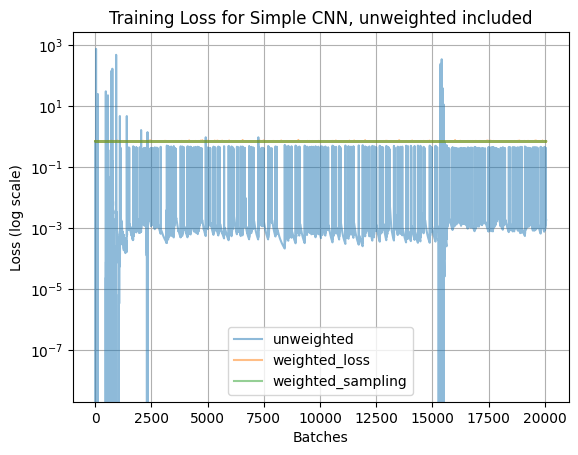

In [ ]:
simple_cnn_df = pd.concat([uw_df["simple_cnn"], wl_df["simple_cnn"], ws_df["simple_cnn"]], axis=1)
simple_cnn_df.columns = ["unweighted", "weighted_loss", "weighted_sampling"]
simple_cnn_df.plot(title="Training Loss for Simple CNN, unweighted included", alpha=0.5, logy=True)
plt.xlabel('Batches')
plt.ylabel('Loss (log scale)')
plt.grid()
plt.show()

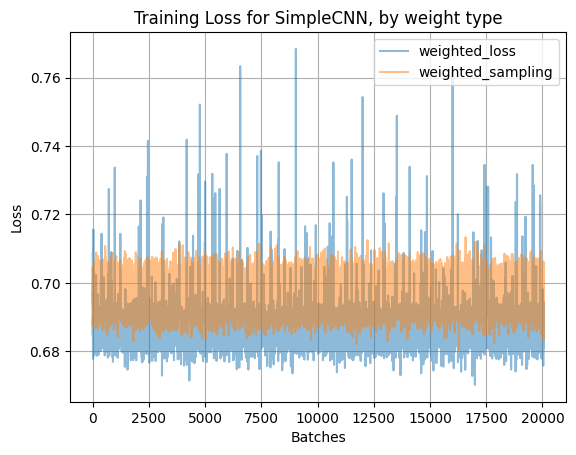

In [ ]:
simple_cnn_df = pd.concat([wl_df["simple_cnn"], ws_df["simple_cnn"]], axis=1)
simple_cnn_df.columns = ["weighted_loss", "weighted_sampling"]
simple_cnn_df.plot(title="Training Loss for SimpleCNN, by weight type", alpha=0.5)
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.grid()
plt.show()

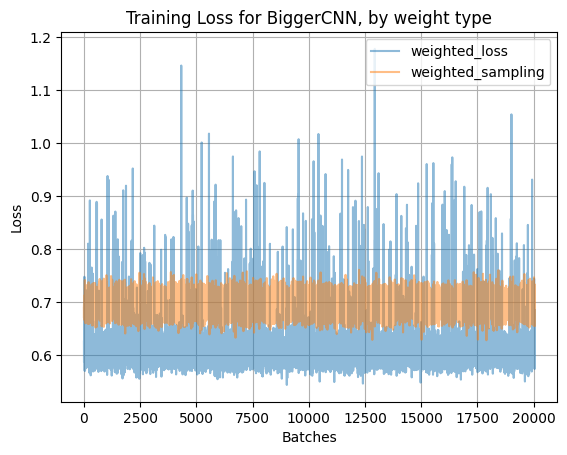

In [ ]:
big_cnn_df = pd.concat([wl_df["big_cnn"], ws_df["big_cnn"]], axis=1)
big_cnn_df.columns = ["weighted_loss", "weighted_sampling"]
big_cnn_df.plot(title="Training Loss for BiggerCNN, by weight type", alpha=0.5)
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.grid()
plt.show()

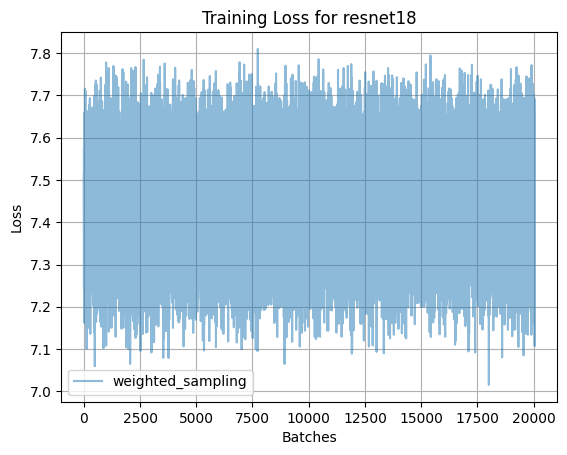

In [ ]:
resnet_df = pd.concat([ws_df["resnet18"]], axis=1)
resnet_df.columns = ["weighted_sampling"]
resnet_df.plot(title="Training Loss for resnet18", alpha=0.5)
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [ ]:
metrics

,simple_cnn,big_cnn,resnet18
Unnamed: 0,,,
unweighted,(' precision recall f1-score ...,NaN,NaN
loss,(' precision recall f1-score ...,(' precision recall f1-score ...,NaN
sampling,(' precision recall f1-score ...,(' precision recall f1-score ...,(' precision recall f1-score ...
